<a href="https://colab.research.google.com/github/Rohit-Singh12/Deep-LEARGNINGS/blob/main/AI%20Agents/SEC-EDGAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Financial Q&A System with Agent Capabilities



#### Agentic RAG that answers questions related to financial analysis of Nvidida, Microsoft and Google


---


#### **Tools Used** -
    1. `langgraph` for Agentic workflow Orchestation
    2. Google Gemini as LLM `(For running use API - key)`
    3. FAISS for in-memory vector store
    4. Used HuggingFace Embedding model - BAAI/bge-large-en-v1.5 for creating vector embedding
    5. Used HuggingFace - BAAI/bge-reranker-large as Cross-Encoder
    6. Used `BeautifulSoup` for extracting the content from SEC-EDGAR pages
    7. For chunking `HTMLSemanticPreservingSplitter` from `langchain` is used as the parsed documents are in HTML format and this cleans up the HTML


---



#### **Overview of the approach-**
    1. Parsed the SEC-EDGAR pages for retreiving the 10-K form content
    2. Since Q&A is related to financial data only following sections were parsed from the 10-K form, which is the standard format for all 10-K so it is easier to target these sections -

          *   Item 1. Business
          *   Item 1A. Risk Factors
          *   Item 7. Management’s Discussion and Analysis of Financial Condition and Results of Operations
          *   Item 7A. Quantitative and Qualitative Disclosures About Market Risk
          *   Item 8. Financial Statements and Supplementary Data
    3. Each of the parsed section is saved separately and later each of these sections are fetched and processed to create embedding.
    4. All the embedding are indexed in FAISS Vector Store, since the content is not very large `Flat Indexing` is used for better accuracy else you can go with `HNSW` or other for fast retreival
    5. Setup the Retreival class for retreival. While retreiving top 50 documents are fetched. Then the fetched document is `re-ranked` for cross-encoders for fetching top-10 most relevant documents.
    6. Created Langgraph workflow with following nodes-
          *   Subquery Node - For generating subqueries from the main query
          *   Retreival Node - For retreiving relevant context from the vectorstore for all the subquries
          *   Context is passed along with main query to `Gemini` for final response. (`result['final_result']` contains final answer of the query)
     

---


**NOTE: While running this ensure to enable `T4-GPU` which is available for free. As for the first time when embedding is generated it takes time so in-order to make this process faster (x10) use GPU.**





#### Install required dependecies
 It will ask to restart session when you run it for first time

In [ ]:
!pip install langchain langchain-community langchain-huggingface faiss-cpu sentence-transformers langgraph langchain-google-genai

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import torch

## Parse SEC-EDGAR 10-K Documents


---



Parse the SEC - Edgar for financial data.
Following section are fetched -
  *   Management’s Discussion and Analysis of Financial Condition and Results of Operations (Before - Quantitative and Qualitative Disclosures About Market Risk)
  *   Quantitative and Qualitative Disclosures About Market Risk (Before -
  Financial Statements and Supplementary Data)
  *   Financial Statements and Supplementary Data (Before - Changes in and Disagreements With Accountants on Accounting and Financial Disclosure)
  *   Business (Before - Risk Factors)
  *   Risk Factors (Before - Unresolved Staff Comments)

In [ ]:
class DocumentLoader:
  def __init__(self):
    # Constants
    self.COMPANY_TICKERS_URL = f"https://www.sec.gov/files/company_tickers.json"
    self.HEADERS = {
        "User-Agent": "Name abc@gmail.com"
    }

  def get_cik_map(self) -> str:
    '''
    Get cik mapping for all companies

    Returns:
      dict: The dictionary containing cik_number of all companies
    '''
    return requests.get(self.COMPANY_TICKERS_URL, headers=self.HEADERS).json()

  def get_cik(self, ticker: str, cik_map: dict) -> str:
    '''
    Fetch the cik of the company which is max 10 digit

    Args:
      ticker (str):  cik ticker code for the company
      cik_map (dict): The cik map containing data of all the companies

    Returns:
      str: The cik number of the company
    '''
    try:
      gen = (comp['cik_str'] for _, comp in cik_map.items() \
                if comp['ticker'] == ticker)

      return next(gen)
    except StopIteration:
      return "Incorrect ticker name or map"
    except Exception as ex:
      return f"{ex}"

  def get_filings(self, cik: str, form_type='10-K'):
    '''
    Fetch page from where the 10-K URL be fetched for last three years

    Args:
      cik (str): cik number of the company
      form_type (str): Form to fetch. Default is 10-K

    Returns:
      pd.DataFrame: Pandas Dataframe containing the URL from where 10-K url can be fetched
    '''
    url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    data = requests.get(url, headers=self.HEADERS).json()
    filings = data["filings"]["recent"]

    df = pd.DataFrame({
        "form": filings['form'],
        "date": filings["filingDate"],
        "accession": filings["accessionNumber"],
        "url": [
            f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{acc.replace('-', '')}/{acc}-index.htm"
            for acc in filings["accessionNumber"]
        ]
    })

    df = df[df['form'] == form_type]
    return df

  def return_10K_url(self, url: str):
    '''
    Get the comapny 10-k filings from the url

    Args:
      url (str): Page url which contains 10-K form URL

    Returns:
      str: The 10-k URL which can directly be used for fetching result
    '''
    res = requests.get(url, headers=self.HEADERS)
    soup = BeautifulSoup(res.content, 'html.parser')
    rows = soup.find_all("tr")
    for row in rows[1:]:  # skip the header row
      cols = row.find_all("td")
      if not cols:
        continue

      doc_type = cols[3].get_text(strip=True)
      if doc_type == '10-K':
        doc_tag = cols[2].find("a")
        if doc_tag:
          doc_url = "https://www.sec.gov/" + doc_tag['href'].replace("/ix?doc=/", '')
          return doc_url
    else:
      raise Exception("10-K document URL not found")

  def save_htm(self, content: str, directory: str, filename: str):
    '''
      Save the HTML content to the path specified.

      Args:
        content (str): Content to save
        directory (str): Directory name. Create if not created already
        filename (str): Filename inside directory

      Returns:
    '''
    import os
    filepath = os.path.join(directory, filename)

    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    # Save the HTML content
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(content)

    print(f"HTML content saved to: {filepath}")

  def get_content(self, start_div, end_div):
    '''
      Parse and fetch the HTML content between the two given HTML tags

      Args:
        start_div (str): HTML tag from where to start parsing
        end_div (str): HTML tag will where parsing will be done

      Returns:
        str: Parsed HTML Content
    '''
    content_between = []
    for sibling in start_div.next_siblings:
      if sibling == end_div:
        break
      content_between.append(str(sibling))  # keep HTML as string

    content_html = "".join(content_between)
    return content_html

  def fetch_data(self, start: str, end: str, soup: BeautifulSoup) -> str:
    '''
      For getting financial data we will only fetch content from following sections. Since all 10-K documents follow this standard it is easier to parse
        relevant sections -

        *   Management’s Discussion and Analysis of Financial Condition and Results of Operations (Before - Quantitative and Qualitative Disclosures About Market Risk)
        *   Quantitative and Qualitative Disclosures About Market Risk (Before -
        Financial Statements and Supplementary Data)
        *   Financial Statements and Supplementary Data (Before - Changes in and Disagreements With Accountants on Accounting and Financial Disclosure)
        *   Business (Before - Risk Factors)
        *   Risk Factors (Before - Unresolved Staff Comments)
    '''
    # start div
    start_tag = soup.find(lambda t: t.get_text(strip=True).lower() == start.lower())
    start_tag = start_tag.find("a")
    assert start_tag != ''
    start_href = start_tag.get('href')
    assert start_href != ''
    start_div = soup.find(id=start_href.replace('#', ''))
    assert start_div != ''

    #end div
    end_tag = soup.find(lambda t: t.get_text(strip=True).lower() == end.lower())
    end_tag = end_tag.find("a")
    assert end_tag != ''
    end_href = end_tag.get('href')
    assert end_href != ''
    end_div = soup.find(id=end_href.replace('#', ''))
    assert end_div != ''

    #get content between start and end
    return self.get_content(start_div, end_div)

  def get_financial_data(self, soup: BeautifulSoup):
    '''
      Fetch the 10-K content of the company

      Args:
        soup (BeautifulSoup): Beautiful Soup object which will be used to parse HTML

      Returns:
        tuple: Tuple containing Risk, Financial Statement, Business model and Risk Factors
    '''
    risk_content = self.fetch_data('Quantitative and Qualitative Disclosures About Market Risk',
                            'Financial Statements and Supplementary Data',
                            soup)
    financial_content = self.fetch_data('Financial Statements and Supplementary Data',
                                'Changes in and Disagreements With Accountants on Accounting and Financial Disclosure',
                                soup)
    financial_content += self.fetch_data('Management’s Discussion and Analysis of Financial Condition and Results of Operations',
                                         'Quantitative and Qualitative Disclosures About Market Risk',
                                         soup)
    business_content = self.fetch_data('Business',
                                'Risk Factors',
                                soup)
    risk_factor_content = self.fetch_data('Risk Factors',
                                  'Unresolved Staff Comments',
                                  soup)

    return (risk_content, financial_content, business_content, risk_factor_content)



In [ ]:
# All companies CIK Ticker code
companies = ['GOOGL', 'MSFT', 'NVDA']

### Parsing the 10-K documents of the companies

In [ ]:
from collections import defaultdict

parser = DocumentLoader()
# This header is required for every request to sec.edgar domain
# else 403 is returned
HEADERS = {
        "User-Agent": "Name abc@gmail.com"
    }

# CIK map dictionary
cik_map = parser.get_cik_map()

# Dictionary to store the 10-k filling of each company
# Keys will be company name and value will be content parsed
company_filings = defaultdict(list)
for company in companies:
  cik = parser.get_cik(company, cik_map)
  cik = str(cik).zfill(10) #size of cik

  #Fetch last three filing (2022, 2023, 2024)
  last_three_filings = parser.get_filings(str(cik))

  for row in range(3):
    filing = last_three_filings.iloc[row, :]
    url = filing['url']
    url_10k = parser.return_10K_url(url)
    print(f"[INFO] Parsing 10-K url {url_10k} of {company}")
    #fetch 10-k data
    res = requests.get(url_10k, headers=HEADERS)
    soup = BeautifulSoup(res.content, 'html.parser')

    #fetch section wise data
    analytics_data = parser.get_financial_data(soup)
    risk_content, financial_content, business_content, risk_factor_content = analytics_data

    date = filing['date']
    #save risk content
    parser.save_htm(risk_content, company, "risk_" + str(date)+ '.html')
    #save financial content
    parser.save_htm(financial_content, company, "financial_" + str(date)+ '.html')
    #save business content
    parser.save_htm(business_content, company, "business_" + str(date)+ '.html')
    #save risk factor content
    parser.save_htm(risk_factor_content, company, "risk_factor_" + str(date)+ '.html')

    company_filings[company].append(analytics_data)

[INFO] Parsing 10-K url https://www.sec.gov/Archives/edgar/data/1652044/000165204425000014/goog-20241231.htm of GOOGL
HTML content saved to: GOOGL/risk_2025-02-05.html
HTML content saved to: GOOGL/financial_2025-02-05.html
HTML content saved to: GOOGL/business_2025-02-05.html
HTML content saved to: GOOGL/risk_factor_2025-02-05.html
[INFO] Parsing 10-K url https://www.sec.gov/Archives/edgar/data/1652044/000165204424000022/goog-20231231.htm of GOOGL
HTML content saved to: GOOGL/risk_2024-01-31.html
HTML content saved to: GOOGL/financial_2024-01-31.html
HTML content saved to: GOOGL/business_2024-01-31.html
HTML content saved to: GOOGL/risk_factor_2024-01-31.html
[INFO] Parsing 10-K url https://www.sec.gov/Archives/edgar/data/1652044/000165204423000016/goog-20221231.htm of GOOGL
HTML content saved to: GOOGL/risk_2023-02-03.html
HTML content saved to: GOOGL/financial_2023-02-03.html
HTML content saved to: GOOGL/business_2023-02-03.html
HTML content saved to: GOOGL/risk_factor_2023-02-03.htm

### Optional saving the Parsed content for future use

In [ ]:
# import shutil

# # Zip the folder
# shutil.make_archive("/content/GOOGL", "zip", "GOOGL")

# # Download the zip
# from google.colab import files
# files.download("GOOGL.zip")

# shutil.make_archive("/content/MSFT", "zip", "MSFT")

# # Download the zip
# files.download("MSFT.zip")

# shutil.make_archive("/content/NVDA", "zip", "NVDA")

# # Download the zip
# files.download("NVDA.zip")

## RAG Agent

### Add API -key for gemini API call ❗



In [ ]:
api_key = '<API-KEY>'

In [ ]:
import os

os.environ["GOOGLE_API_KEY"] = api_key

### Vector Store Handler

Storing Embedding in In-memory vector store FAISS

---

**Chunking Strategy**-

1.   `HTMLSemanticPreserviceSplitter` is used from `langchain` for semantically chunking HTML content.
2.   While chunking ensured that one complete `table` data goes in single chunk so that *context is not lost*

---

**Indexing** -
 `Flat Indexing` is used for while creating Indexes as content is small and it will provide better accuracy and memory usage will not go high



---


**Retreival**
`Retreival` -  While retreival by-default `top-50` contexts are fetched and after that the fetched results are re-ranked with `Cross-encoder` and `top-10` results are fetched only





In [ ]:
import os
from typing import List, Dict, Any

from bs4 import BeautifulSoup
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import HTMLSemanticPreservingSplitter
import numpy as np
import faiss
import pickle
from sentence_transformers import CrossEncoder

In [ ]:
class SECVectorStore:
  def __init__(self, model_name="BAAI/bge-large-en-v1.5", reranker_name="BAAI/bge-reranker-large"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    self.embedder = HuggingFaceEmbeddings(model_name=model_name,
                                          model_kwargs={"device": device})
    self.text_splitter = HTMLSemanticPreservingSplitter(
        headers_to_split_on=[
                              ("h1", "header1"),
                              ("h2", "header2"),
                              ("h3", "header3"),
                              ("h4", "header4"),
                              ("h5", "header5"),
                              ("h6", "header6"),
                              ("p", "paragraph"),
                              ("div", "div")
                            ],
        max_chunk_size=1000,
        preserve_links=True,
        preserve_images=True,
        chunk_overlap=200,
        elements_to_preserve=['table']
    )
    self.index = None
    self.index_cpu = None
    self.metadatas = []
    self.reranker = CrossEncoder(reranker_name, device=device)

  def chunk_html(self, html_content: str, company: str, year: str) -> List[Dict[str, Any]]:
    """Parse HTML <body>, split sibling <div>s into chunks"""
    if "<body" not in html_content.lower():
      html_content = f"<body>{html_content}</body>"
    soup = BeautifulSoup(html_content, "html.parser")
    body = soup.find("body")
    if not body:
      raise Exception("Without body further process isn't possible")

    chunks = []
    for outer_idx, tag in enumerate(body.find_all(recursive=False)):  # direct children only
      # Remove only inline styles (and optionally other noisy attrs)
      for descendant in tag.descendants:
        if hasattr(descendant, "attrs"):
          descendant.attrs.pop("style", None)

      cleaned_html = str(tag).strip()
      text = tag.get_text(separator=" ", strip=True)
      if len(text.split()) > 30:  # ignore very small divs
        split_texts = self.text_splitter.split_text(cleaned_html)
        for inner_idx, chunk in enumerate(split_texts):
          chunks.append({
            "text": chunk.page_content,
            "metadata": {
              "company": company,
              "year": year,
              "chunk_id": f"{outer_idx}_{inner_idx}",
              # "html": cleaned_html,
              "text": chunk.page_content
            }
          })
    return chunks

  def build_index(self, all_docs: List[Dict[str, Any]]):
    """Build FAISS index from docs"""
    print("[INFO]: Building Index")
    texts = [doc["text"] for doc in all_docs]
    metadatas = [doc["metadata"] for doc in all_docs]

    print("[INFO]: Creating Embeddings")
    # Step 1: Embed all chunks
    embeddings = self.embedder.embed_documents(texts)
    embeddings = np.array(embeddings, dtype=np.float32)

    print("[INFO]: Adding Embeddings to Index")
    # Step 2: Build FAISS index
    index = faiss.IndexFlatIP(embeddings.shape[1])  # Inner product similarity

    index.add(embeddings)
    self.index = index
    self.metadatas = metadatas

    faiss.write_index(self.index, "faiss.index")
    with open("faiss_metadata.pkl", "wb") as f:
      pickle.dump(self.metadatas, f)
    print("[INFO] Index saved to 'faiss.index'")

  def load_index(self, path="faiss.index"):
    """Load index on CPU for retrieval"""
    print("[INFO] Loading index on CPU...")
    self.index_cpu = faiss.read_index(path)
    with open("faiss_metadata.pkl", "rb") as f:
      self.metadatas = pickle.load(f)
    print("[INFO] Index and metadata loaded successfully.")

  def retrieve(self, query: str, k: int, n_fetch: int):
    """Retrieve top-k relevant chunks for query"""
    if self.index_cpu is None:
      raise ValueError("Index not loaded. Call load_index() first.")

    query_emb = self.embedder.embed_query(query)
    query_emb = np.array([query_emb], dtype=np.float32)

    D, I = self.index_cpu.search(query_emb, k)
    results = []
    for idx in I[0]:
      if idx < len(self.metadatas):
        meta_copy = self.metadatas[idx].copy()
        meta_copy.pop("text", None)
        results.append({
            "text": self.metadatas[idx]["text"] if "text" in self.metadatas[idx] else "",
            "metadata": meta_copy
        })

    # Cross - Encoding for re-ranking
    pairs = [(query, doc['text']) for doc in results]
    cross_scores = self.reranker.predict(pairs)

    for doc, c_score in zip(results, cross_scores):
      doc['cross_score'] = float(c_score)

    reranked = sorted(results, key=lambda x : x['cross_score'], reverse=True)
    return reranked[:n_fetch]

In [ ]:
directories = ["GOOGL", "MSFT", "NVDA"]
company_map = {"GOOGL": "Google", "MSFT": "Microsoft", "NVDA": "Nvidia"}
from pathlib import Path

vs = SECVectorStore()
all_docs = []

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

/tmp/ipython-input-1212680918.py:6: LangChainBetaWarning: The class `HTMLSemanticPreservingSplitter` is in beta. It is actively being worked on, so the API may change.
  self.text_splitter = HTMLSemanticPreservingSplitter(


config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [ ]:
for directory in directories:
  for file_path in Path(directory).glob("*.html"):
    if file_path.is_file():
      # Extract filename without extension
      filename = file_path.stem

      # Extract year (split on "_" then take first 4 digits from date part)
      try:
        year = filename.split("_")[-1].split("-")[0]
      except IndexError:
        print("[ERROR]: IMPORTANT: Exception not fetched year")
        continue
      print(str(int(year)-1), company_map[directory], filename)
      with open(file_path, "r", encoding='utf-8', errors='ignore') as f:
        content = f.read()
        # soup = BeautifulSoup(content, "html.parser")
        #-----------
        #  Ingestion
        #-----------
        all_docs.extend(vs.chunk_html(content, company_map[directory], year))


#--------
#  Store
#--------
vs.build_index(all_docs)


2024 Google business_2025-02-05
2022 Google risk_2023-02-03
2024 Google risk_2025-02-05
2022 Google business_2023-02-03
2024 Google financial_2025-02-05
2022 Google financial_2023-02-03
2023 Google business_2024-01-31
2022 Google risk_factor_2023-02-03
2024 Google risk_factor_2025-02-05
2023 Google financial_2024-01-31
2023 Google risk_factor_2024-01-31
2023 Google risk_2024-01-31
2023 Microsoft business_2024-07-30
2022 Microsoft risk_factor_2023-07-27
2022 Microsoft financial_2023-07-27
2024 Microsoft financial_2025-07-30
2023 Microsoft financial_2024-07-30
2024 Microsoft risk_factor_2025-07-30
2024 Microsoft risk_2025-07-30
2023 Microsoft risk_2024-07-30
2024 Microsoft business_2025-07-30
2023 Microsoft risk_factor_2024-07-30
2022 Microsoft business_2023-07-27
2022 Microsoft risk_2023-07-27
2022 Nvidia risk_factor_2023-02-24
2024 Nvidia business_2025-02-26
2022 Nvidia financial_2023-02-24
2022 Nvidia business_2023-02-24
2023 Nvidia business_2024-02-21
2023 Nvidia financial_2024-02-21

In [ ]:
vs.load_index()

[INFO] Loading index on CPU...
[INFO] Index and metadata loaded successfully.


## Build Graph

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
import json

In [ ]:
# -----------------------------
# 2. Agents (LangGraph Nodes)
# -----------------------------

# Gemini client
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)


def subquery_agent(state: Dict) -> Dict:
    """Decompose complex query into subqueries with structured JSON output"""
    print("[INFO]: Inside SUBQUERY agent")
    query = state["query"]

    prompt = f"""
      You are a financial query decomposition agent.

      ## Instructions:
      - Given the query: "{query}"
      - Break it into optimized sub-queries focused on company (Google, Microsoft, Nvidia),
        metric (revenue, margin, risk factor, business, etc.), and year (2022, 2023, 2024).
      - Return a JSON list of dictionaries where each dictionary must have a "subquery" key.
      - Include "company", "metric", "year" or "years" only if you can identify them from the query.
      - Do NOT include any text outside the JSON.
      - The JSON must be valid and parseable by Python's `json.loads`.

      ## Example:

      Input query: "Which company had the highest operating margin in 2023?"

      Output JSON:

      [
        {{
          "company": "Microsoft",
          "metric": "operating margin",
          "year": "2023",
          "subquery": "Microsoft operating margin 2023"
        }},
        {{
          "company": "Google",
          "metric": "operating margin",
          "year": "2023",
          "subquery": "Google operating margin 2023"
        }},
        {{
          "company": "NVIDIA",
          "metric": "operating margin",
          "year": "2023",
          "subquery": "NVIDIA operating margin 2023"
        }}
      ]

      Remember:
      - Always return a **list of dictionaries**.
      - Each dict must contain **"subquery"** key.
      - Other keys ("company", "metric", "year", "years") are optional if available.
      - No markdown, no explanation, only JSON.
      """

    resp = llm.invoke(prompt)
    # Strip and save JSON string
    state["sub_queries"] = resp.content.strip()
    return state


def retrieval_agent(state: Dict, vectorstore: SECVectorStore, k: int = 50, n_fetch:int = 10) -> Dict:
    """Retrieve top-k relevant chunks for each subquery"""
    print("[INFO]: Inside Retrieval Agent")
    all_results = []
    sub_queries = state['sub_queries']
    cleaned = sub_queries.replace("```json", "").replace("```", "")
    data = json.loads(cleaned)
    for sq in data:
        docs = vectorstore.retrieve(sq['subquery'], k, n_fetch)
        for d in docs:
            all_results.append({
                "subquery": sq['subquery'],
                "text": d['text'],
                "metadata": d['metadata']
            })

    state["retrieved"] = all_results
    return state


def generation_agent(state: Dict) -> Dict:
    print("[INFO]: Inside Generation Agent")
    """Synthesize final structured JSON answer"""
    query = state["query"]
    sub_queries = state["sub_queries"]
    retrieved = state["retrieved"]
    context_lines = []
    for item in retrieved:
        # Each item has 'subquery' and 'source'
        context_lines.append(f"Subquery: {item['subquery']}\nSource Text: {item['text']}\n---")

    context_str = "\n".join(context_lines)
    prompt = f"""
      You are a financial reasoning agent that answers queries based on provided company filings.

      ## Instructions:
      - Use the retrieved content to answer the query.
      - Produce a JSON output ONLY, with the following fields:
        - "query": repeat the original query.
        - "answer": a concise, factual answer.
        - "reasoning": step-by-step explanation of how you derived the answer from the content.
        - "sub_queries": list of the sub-queries that were executed.
        - "sources": list of relevant sources, each with:
            - "company": company name (MSFT, GOOGL, NVDA)
            - "year": the fiscal year
            - "excerpt": a relevant snippet from the document

      ## Context:
      Below is the list of retrieved chunks. Each chunk is a dictionary with "text" and "metadata" fields.

      {context_str}

      ## Query:
      {query}

      ## Sub-queries executed:
      {sub_queries}

      ## Requirements:
      - Use information only from the retrieved chunks.
      - Pick the most relevant excerpt for each source.
      - Ensure JSON is valid and parseable.
      - Avoid any commentary outside JSON.

      Example output:

      {{
          "query": "Which company had the highest operating margin in 2023?",
          "answer": "Microsoft had the highest operating margin at 42.1% in 2023...",
          "reasoning": "Retrieved operating margins for all three companies from their 2023 10-K filings and compared values.",
          "sub_queries": [
              "Microsoft operating margin 2023",
              "Google operating margin 2023",
              "NVIDIA operating margin 2023"
          ],
          "sources": [
              {{
                  "company": "MSFT",
                  "year": "2023",
                  "excerpt": "Operating margin was 42.1%..."
              }},
              {{
                  "company": "GOOGL",
                  "year": "2023",
                  "excerpt": "Operating margin of 29.8%..."
              }},
              {{
                  "company": "NVDA",
                  "year": "2023",
                  "excerpt": "Operating margin of 29.6%..."
              }}
          ]
      }}
    """


    resp = llm.invoke(prompt)
    state["final_answer"] = resp.content.strip()
    return state


# -----------------------------
# 3. LangGraph Workflow
# -----------------------------
def build_workflow(vectorstore: SECVectorStore):
    graph = StateGraph(dict) # Use pydantic for proper validation

    graph.add_node("subquery", subquery_agent)
    graph.add_node("retrieval", lambda state: retrieval_agent(state, vectorstore))
    graph.add_node("generation", generation_agent)

    graph.set_entry_point("subquery")
    graph.add_edge("subquery", "retrieval")
    graph.add_edge("retrieval", "generation")
    graph.add_edge("generation", END) # Add evaluator Agent for better results

    return graph.compile()

In [ ]:
workflow = build_workflow(vs)

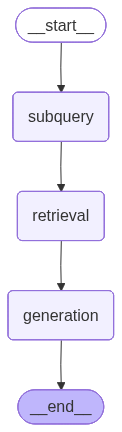

In [ ]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

### Write you Query Here ⬇

In [ ]:
query = "How much Microsof naf Google earn from Cloud?"
result = workflow.invoke({"query": query})

[INFO]: Inside SUBQUERY agent
[INFO]: Inside Retrieval Agent
[INFO]: Inside Generation Agent


### Final output

Final output is in `final_answer`

In [ ]:
json.loads(result['final_answer'].replace("```json",'').replace('```',''))

{'query': 'How much Microsof naf Google earn from Cloud?',
 'answer': 'In fiscal year 2022, Microsoft earned $91.4 billion from cloud services; in 2023, $111.6 billion; and in 2024, $137.4 billion.  Google Cloud revenue was $26.28 billion in 2022, $33.09 billion in 2023, and $43.23 billion in 2024.',
 'reasoning': "The answer was derived by extracting Microsoft's cloud revenue figures from multiple excerpts which stated that Microsoft Cloud revenue was $91.4 billion in fiscal year 2022, $111.6 billion in fiscal year 2023, and $137.4 billion in fiscal year 2024.  Google's cloud revenue was extracted from excerpts showing $26.28 billion in 2022, $33.088 billion in 2023, and $43.229 billion in 2024.",
 'sub_queries': [{'company': 'Microsoft',
   'metric': 'Cloud revenue',
   'years': '2022, 2023, 2024',
   'subquery': 'Microsoft Cloud revenue 2022, 2023, 2024'},
  {'company': 'Google',
   'metric': 'Cloud revenue',
   'years': '2022, 2023, 2024',
   'subquery': 'Google Cloud revenue 2022,